In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import importlib
import attrs

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

In [3]:
X, y = attrs.dataset_loader()

In [4]:
X.shape

(27558, 50, 50, 3)

Text(0.5, 1.0, 'Parasitized')

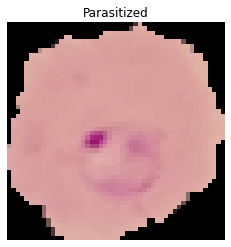

In [5]:
plt.imshow(X[y == 1][0])
plt.axis("off")
plt.title("Parasitized")

Text(0.5, 1.0, 'Not Parasitized')

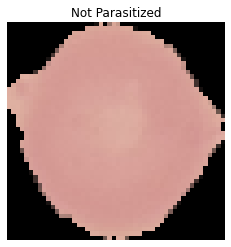

In [6]:
plt.imshow(X[y == 0][0])
plt.axis("off")
plt.title("Not Parasitized")

e:\Program files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

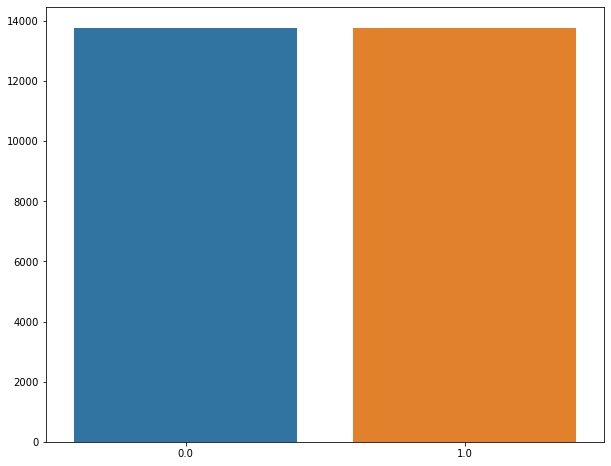

In [7]:
unique, count = np.unique(y, return_counts=True)
plt.figure(figsize=(10,8))
sns.barplot(unique, y=count)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

x_train shape:  (19290, 50, 50, 3)
x_test shape:  (8268, 50, 50, 3)
y_train shape:  (19290,)
y_test shape:  (8268,)


### ML models

In [ ]:
pipeline = Pipeline([
    ("ravel_array", attrs.ArrayRavel())
])
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.fit_transform(X_test)

In [ ]:
# using random forest classifer is like using svm like this: svc_clf = SVC(C=1000, kernel="rbf", gamma=0.1)
# SVM takes a very long time to train and check for cross validation.
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=24, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(max_leaf_nodes=24, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [ ]:
rnd_scores = attrs.cross_val_score(rnd_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(rnd_scores)

Scores:  [0.72472784 0.72472784 0.718507   0.72706065 0.71772939 0.7192846
 0.70917574 0.70995334 0.718507   0.7192846  0.73250389 0.718507
 0.72939347 0.70451011 0.73172628]
Mean:  0.7203732503888024
Standard deviation:  0.007939190680000123


- RandomForest is severly underfitting the dataset

In [ ]:
# let's try ada boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=8), n_estimators=500, algorithm="SAMME.R", random_state=42, learning_rate=0.5)
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=8),
                   learning_rate=0.5, n_estimators=500, random_state=42)

In [ ]:
ada_scores = attrs.cross_val_score(ada_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(ada_scores)

In [ ]:
importlib.reload(attrs)

<module 'attrs' from 'd:\\Machine learning\\Projects\\Malaria Cell Predictor\\attrs.py'>

In [ ]:
import xgboost

xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train_prepared, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=4)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
              

In [ ]:
xgb_scores = attrs.cross_val_score(xgb_clf, X_train_prepared, y_train, n=15)
attrs.display_cross_val_score(xgb_scores)

Scores:  [0.63685848 0.62674961 0.63763608 0.6407465  0.63374806 0.64463453
 0.64774495 0.65163297 0.63530327 0.64852255 0.65007776 0.655521
 0.64385692 0.64930016 0.63608087]
Mean:  0.6425609123898394
Standard deviation:  0.0077587504132170726


### NN models

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
root_logdir = os.path.join(os.curdir, "logs")

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

def get_run_logdir(name=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") + f"- {name}"
    return os.path.join(root_logdir, run_id)

In [11]:
X_train_prepared, X_valid_prepared, y_train_prepared, y_valid_prepared = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
X_train_prepared.shape

(15432, 50, 50, 3)

In [13]:
import keras.backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Model 1

In [14]:
nn_model = keras.Sequential()
nn_model.add(keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(50,50,3)))
nn_model.add(keras.layers.MaxPool2D(2))
nn_model.add(keras.layers.Dropout(0.2))

nn_model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
nn_model.add(keras.layers.MaxPool2D(2,2))
nn_model.add(keras.layers.Dropout(0.3))

nn_model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
nn_model.add(keras.layers.MaxPool2D(2,2))
nn_model.add(keras.layers.Dropout(0.3))

nn_model.add(keras.layers.Flatten())
nn_model.add(keras.layers.Dense(64,activation='relu'))
nn_model.add(keras.layers.Dropout(0.5))

nn_model.add(keras.layers.Dense(1,activation='sigmoid'))

In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/nn_model_1.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("nn_model_1"))

nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[f1_score])

In [16]:
X_train_prepared[0].size * X_train_prepared.itemsize / 10**9

3e-05

In [17]:
history = nn_model.fit(X_train_prepared, y_train_prepared, 
                        epochs=30,
                        validation_data=(X_valid_prepared, y_valid_prepared),
                        callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
483/483 [==============================] - 9s 12ms/step - loss: 0.6179 - f1_score: 0.6192 - val_loss: 0.4014 - val_f1_score: 0.8061
Epoch 2/30
483/483 [==============================] - 5s 9ms/step - loss: 0.2669 - f1_score: 0.8985 - val_loss: 0.1791 - val_f1_score: 0.9354
Epoch 3/30
483/483 [==============================] - 5s 11ms/step - loss: 0.2057 - f1_score: 0.9304 - val_loss: 0.1636 - val_f1_score: 0.9447
Epoch 4/30
483/483 [==============================] - 4s 9ms/step - loss: 0.1884 - f1_score: 0.9367 - val_loss: 0.1648 - val_f1_score: 0.9499
Epoch 5/30
483/483 [==============================] - 5s 10ms/step - loss: 0.1748 - f1_score: 0.9405 - val_loss: 0.1501 - val_f1_score: 0.9523
Epoch 6/30
483/483 [==============================] - 5s 10ms/step - loss: 0.1731 - f1_score: 0.9443 - val_loss: 0.1421 - val_f1_score: 0.9505
Epoch 7/30
483/483 [==============================] - 5s 9ms/step - loss: 0.1601 - f1_score: 0.9461 - val_loss: 0.1421 - val_f1_score: 0.9530
Ep

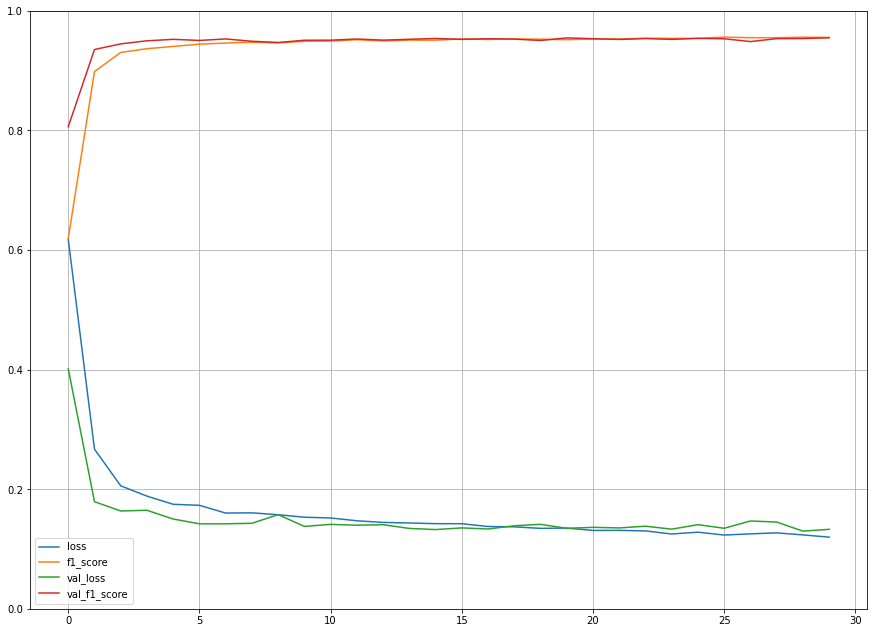

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
nn_model.evaluate(X_test, y_test)

259/259 [==============================] - 1s 5ms/step - loss: 0.1413 - f1_score: 0.9527


[0.1412668526172638, 0.9526795744895935]

### Model 2

In [21]:
nn_model_2 = keras.Sequential()
nn_model_2.add(keras.layers.Conv2D(16, 7, activation='relu', padding="same", input_shape=(50,50,3)))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Conv2D(64, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.Conv2D(64, 3, activation='relu', padding="same"))
nn_model_2.add(keras.layers.MaxPool2D(2))

nn_model_2.add(keras.layers.Flatten())
nn_model_2.add(keras.layers.Dense(64, activation='relu'))
nn_model_2.add(keras.layers.Dropout(0.5))

nn_model_2.add(keras.layers.Dense(1, activation='sigmoid'))

In [22]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/nn_model_2.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir("nn_model_2"))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

nn_model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=[f1_score])

In [23]:
history = nn_model_2.fit(X_train_prepared, y_train_prepared, 
                        epochs=60,
                        validation_data=(X_valid_prepared, y_valid_prepared),
                        callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Epoch 1/60
483/483 [==============================] - 7s 13ms/step - loss: 0.4917 - f1_score: 0.6795 - val_loss: 0.1867 - val_f1_score: 0.9292
Epoch 2/60
483/483 [==============================] - 6s 12ms/step - loss: 0.1658 - f1_score: 0.9451 - val_loss: 0.1420 - val_f1_score: 0.9541
Epoch 3/60
483/483 [==============================] - 5s 11ms/step - loss: 0.1469 - f1_score: 0.9509 - val_loss: 0.1332 - val_f1_score: 0.9552
Epoch 4/60
483/483 [==============================] - 5s 11ms/step - loss: 0.1367 - f1_score: 0.9523 - val_loss: 0.1361 - val_f1_score: 0.9572
Epoch 5/60
483/483 [==============================] - 5s 11ms/step - loss: 0.1321 - f1_score: 0.9549 - val_loss: 0.1328 - val_f1_score: 0.9545
Epoch 6/60
483/483 [==============================] - 6s 12ms/step - loss: 0.1267 - f1_score: 0.9559 - val_loss: 0.1308 - val_f1_score: 0.9589
Epoch 7/60
483/483 [==============================] - 6s 12ms/step - loss: 0.1200 - f1_score: 0.9561 - val_loss: 0.1410 - val_f1_score: 0.9528

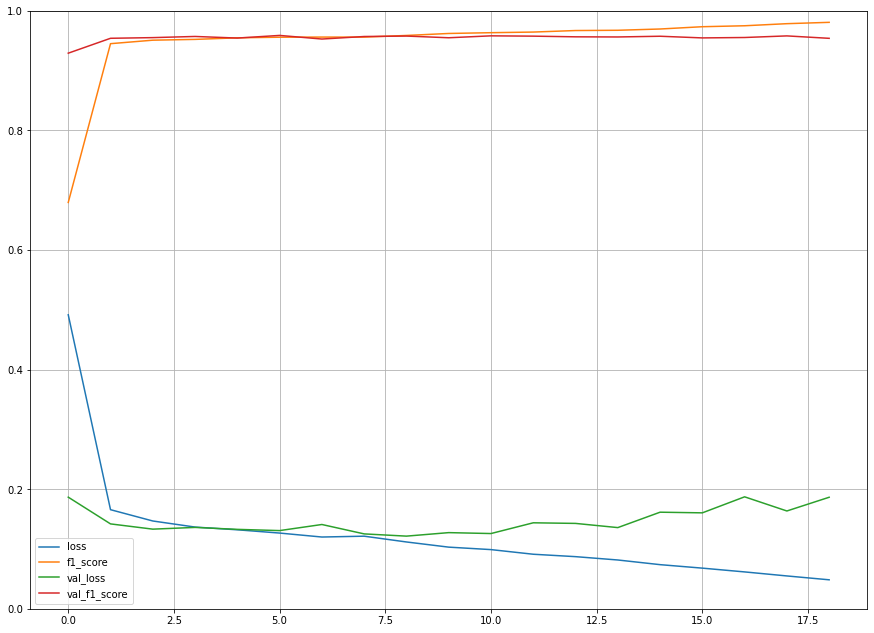

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(15, 11))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
nn_model_2.evaluate(X_test, y_test)

259/259 [==============================] - 1s 5ms/step - loss: 0.2086 - f1_score: 0.9497


[0.20857392251491547, 0.949697732925415]

In [27]:
# model 2 best

nn_model_2 = keras.models.load_model("models/nn_model_2.h5", custom_objects={'f1_score': f1_score})
nn_model_2.evaluate(X_test, y_test)

259/259 [==============================] - 2s 5ms/step - loss: 0.1282 - f1_score: 0.9583


[0.12820686399936676, 0.9582731127738953]